# **⭕Lung Tumor Detection And Segmentation Notebook**



# **⚡Task1: Data Preparation...**

## **✅Problem Definition:**

**`Dataset`**\
├── train\
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── detections\
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── images\
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── masks\
└── val\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── detections\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── images\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── masks
- (detections, images, masks) in both trian & val should have subfolders one for each patient (subject).
- Images and masks should be corresponding to each other and named the same.
- Detections of each patient should include text files named with the scan number.
- Each scan file includes a line or more of 4 numbers each (xMin, yMin, xMax, yMax).

**`Problem:`**
Building **Detection & Segmentation models** for lung-cancer tumors

**`Solution:`**\
1- Handle folders and paths in clean way.
2- Apply and Train Yolo Object Detection Model.  
3- Apply and Train UNet Segmentation Model for full images.  
4- Apply and Train UNet Segmentation Model for cropped detection image.  
5- Performance of valid data and decide which technique is the best from 2 or 3.

## **✅Import Libraries:**

In [ ]:
%pip install ultralytics
!pip install ultralytics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from seaborn import color_palette
from sklearn.metrics import accuracy_score

import os
from zipfile import ZipFile
import cv2
import random
import shutil
import yaml
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO
from tqdm import tqdm
from glob import glob

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

## **✅Dataset Loading:**

In [ ]:
class DataLoader:
    def __init__(self, dataset_path='/content/LungTumorDetectionAndSegmentation.zip', loading_destination='datasets/'):
        self.dataset_path = dataset_path
        self.loading_destination = loading_destination
        self.train_path = os.path.join(loading_destination, 'train')
        self.val_path = os.path.join(loading_destination, 'val')

    def load_data(self):
        '''Reads the training & validation data from the train_path & val_path.
        Returns 2 dictionaries.
        Each one has string keys as the scanID (ex: "Subject0_0).
        And each value is a list of [Image, Mask, detections_list]
        where detections list may include 0 or more lists
        of 4 numbers eachlocating the bounding box'''
        # Extract the original dataset directory
        if os.path.normpath(self.loading_destination) != '.':
            if os.path.exists(self.loading_destination):
                shutil.rmtree(self.loading_destination)
            os.makedirs(self.loading_destination)
        with ZipFile(self.dataset_path, 'r') as zip_ref:
            zip_ref.extractall(self.loading_destination)

        # Read and Print the images shape
        self.image_height, self.image_width = cv2.imread(f"{self.train_path}/images/Subject_20/110.png", cv2.IMREAD_UNCHANGED).shape
        print(f"The dataset consists of {self.image_height} x {self.image_width} grayscale images\n")

        def delete_old_directories(data_path):
            '''Removes the original dataset folders that are not needed anymore'''
            shutil.rmtree(os.path.join(data_path, 'images'))
            shutil.rmtree(os.path.join(data_path, 'masks'))
            shutil.rmtree(os.path.join(data_path, 'detections'))
            os.rename(os.path.join(data_path, 'all_images/'), os.path.join(data_path, 'images'))
            os.rename(os.path.join(data_path, 'all_masks/'), os.path.join(data_path, 'masks'))
            os.rename(os.path.join(data_path, 'all_detections/'), os.path.join(data_path, 'detections'))

        def report_loading(data_path):
            '''Counts the number of scans that do/doesn't have cancer detections data_path"'''
            images_count = len(os.listdir(f'{data_path}/images'))
            detections_count = len(os.listdir(f'{data_path}/detections'))
            healthy_count = images_count - detections_count
            print(f'Loaded [{images_count}] Scans ({detections_count} Cancer + {healthy_count} Healthy)')

        # Load the basic Data
        print('[Loading Training Data  ]  ', end='')
        self.__organize(self.train_path)
        delete_old_directories(self.train_path)
        report_loading(self.train_path)

        print('[Loading Validation Data]  ', end='')
        self.__organize(self.val_path)
        delete_old_directories(self.val_path)
        report_loading(self.val_path)

        self.__generate_cropped_data(self.train_path)
        self.__generate_cropped_data(self.val_path)
        print('\n[INFO]\nReorganized File Structure to:\n-images/\n-masks/\n-detections/\n' +
              '-images_and_detections/\n-cropped_images/\n-cropped_masks')

    def random_scans(self, num_scans):
        '''Retrurns a list of length num_scans of tuples
        of images and their corresponding detections.
        A detection will be returned as [xmin, ymin, xmax, ymax]'''
        images_path = os.path.join(self.train_path, 'images/')
        image_names = random.sample(os.listdir(images_path), num_scans)
        random_images = []
        for name in image_names:
            img = cv2.imread(os.path.join(images_path, name), cv2.IMREAD_GRAYSCALE)
            random_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        detectinos_path = os.path.join(self.train_path, 'images_and_detections/')
        random_detections = []
        for name in image_names:
            scanID = os.path.splitext(name)[0]
            det_path = os.path.join(detectinos_path, f'{scanID}.txt')
            random_detections.append(self.__read_detections(det_path))

        return [(img, dets) for img, dets in zip(random_images, random_detections)]

    def __organize(self, data_path):
        '''Organizes the data in data_path (train / val) into 4 folders:
        all_images/ all_masks/ all_detections/ images_and_detections/
        Placing all of them under data_path'''
        all_images_path = f'{data_path}/all_images/'
        all_masks_path = f'{data_path}/all_masks/'
        all_detections_path = f'{data_path}/all_detections/'
        images_and_detections_path = f'{data_path}/images_and_detections/'
        for path in [all_images_path, all_masks_path, all_detections_path, images_and_detections_path]:
            if os.path.exists(path):
                shutil.rmtree(path)
            os.makedirs(path)

        for patient in os.listdir(os.path.join(data_path, 'images/')):
            for image_name in os.listdir(os.path.join(data_path, 'images/', patient)):
                image_path = os.path.join(data_path, 'images/', patient, image_name)
                scan_ID, extension = os.path.splitext(image_name)
                scan_ID = patient + '_' + scan_ID

                image_copy_path = os.path.join(all_images_path, f'{scan_ID}.png')
                shutil.copy(image_path, image_copy_path)
                image_copy_path = os.path.join(images_and_detections_path, f'{scan_ID}.png')
                shutil.copy(image_path, image_copy_path)

            for mask_name in os.listdir(os.path.join(data_path, 'masks/', patient)):
                mask_path = os.path.join(data_path, 'masks/', patient, mask_name)
                scan_ID, extension = os.path.splitext(mask_name)
                scan_ID = patient + '_' + scan_ID

                mask_copy_path = os.path.join(all_masks_path, f'{scan_ID}.png')
                shutil.copy(mask_path, mask_copy_path)

            for det_name in os.listdir(os.path.join(data_path, 'detections/', patient)):
                detection_path = os.path.join(data_path, 'detections/', patient, det_name)
                self.__normalize_detections(detection_path)

                scan_ID, extension = os.path.splitext(det_name)
                scan_ID = patient + '_' + scan_ID
                detection_copy_path = os.path.join(images_and_detections_path, f'{scan_ID}.txt')
                shutil.copy(detection_path, detection_copy_path)
                detection_copy_path = os.path.join(all_detections_path, f'{scan_ID}.txt')
                shutil.copy(detection_path, detection_copy_path)

    def __normalize_detections(self, path):
        '''Normalizes detections written in the file placed in path for yolo
        to be on this format: [classID, bbox_x_center, bbox_y_center, bbox_width, bbox_height]'''
        detections = []
        if not os.path.exists(path):
            print(f'Error: Reading a detection from a non-existent path')
            return ()
        with open(path, 'r') as file:
            for line in file:
                xmin, ymin, xmax, ymax = [int(num.strip()) for num in line.split(',')]
                bbox_x_center = (xmin + xmax) / 2 / self.image_width
                bbox_y_center = (ymin + ymax) / 2 / self.image_height
                bbox_width = (xmax - xmin) / self.image_width
                bbox_height = (ymax - ymin) / self.image_height
                coordinates = f'0 {bbox_x_center} {bbox_y_center} {bbox_width} {bbox_height}'
                detections.append(coordinates)
            with open(path, 'w') as file:
                file.write('\n'.join(detections))

    def __read_detections(self, dets_path, yolo_normalization=False):
        '''Reads the detections of one image whose detections file is placed dets_path.
        This text file should include 5 whitespace-separated numbers normalized for yolo:
        [class_id, bbox_x_center, bbox_y_center, bbox_width, bbox_height]
        To convert them back to [xmin, ymin, xmax, ymax], raise the unnormalize flag'''
        if not os.path.exists(dets_path):
            return []
        detections = []
        file = open(dets_path, 'r')
        for line in file:
            det = [float(num.strip()) for num in line.split(' ')]
            if yolo_normalization:
                detections.append(det[1:])
                continue
            class_id, bbox_x_center, bbox_y_center, bbox_width, bbox_height = det
            xmin = int(bbox_x_center * self.image_width - bbox_width * self.image_width/2)
            ymin = int(bbox_y_center * self.image_height - bbox_height * self.image_height/2)
            xmax = int(bbox_x_center * self.image_width + bbox_width * self.image_width/2)
            ymax = int(bbox_y_center * self.image_height + bbox_height * self.image_height/2)
            detections.append([xmin, ymin, xmax, ymax])
        file.close()
        return detections

    def __generate_cropped_data(self, destination=''):
        self.__generate_cropped_data(self.train_path)
        self.__generate_cropped_data(self.val_path)

    def __generate_cropped_data(self, data_path):
        '''Crops the images & masks from images/ & masks/ located under dat_path,
        which also has images_and_detections/ that is used to crop.'''
        cropped_images_path = os.path.join(data_path, 'cropped_images/')
        cropped_masks_path = os.path.join(data_path, 'cropped_masks/')
        for path in [cropped_images_path, cropped_masks_path]:
            if os.path.exists(path):
                shutil.rmtree(path)
            os.makedirs(path)

        for image_name in os.listdir(os.path.join(data_path, 'images/')):
            scanID, extension = os.path.splitext(image_name)
            det_path = os.path.join(data_path, 'images_and_detections/', f'{scanID}.txt')
            if not os.path.exists(det_path):
                continue

            image_path = os.path.join(data_path, 'images/', image_name)
            mask_path = os.path.join(data_path, 'masks/', image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            detections = self.__read_detections(det_path)
            for i, det in enumerate(detections):
                xmin, ymin, xmax, ymax = det
                cropped_image = image[ymin:ymax, xmin:xmax]
                cropped_mask = mask[ymin:ymax, xmin:xmax]

                cropped_image = cv2.resize(cropped_image, (self.image_width, self.image_height))
                cropped_mask = cv2.resize(cropped_mask, (self.image_width, self.image_height))

                cropped_img_dst = os.path.join(cropped_images_path, f"{scanID}_tumor{i+1}.png")
                cropped_mask_dst = os.path.join(cropped_masks_path, f"{scanID}_tumor{i+1}.png")
                cv2.imwrite(cropped_img_dst, cropped_image)
                cv2.imwrite(cropped_mask_dst, cropped_mask)

    def __rebuild_masks(self, cropped_masks_path, detections_path, destination):
        def rebuild_mask(cropped_mask_path, detection, canvas):
            '''Reconstrcuts the original mask from the zoomed-in cropped mask located at "cropped_mask_path".
            Detection is a list of 4 number normalized for yolo : [box_xcenter, box_ycenter, box_width, box_height]
            Using "detection", it resizees this cropped mask to the original size
            and places it on the given canvas. If no canvas was given, a blank one is created by defualt.'''
            big_box = cv2.imread(cropped_mask_path, cv2.IMREAD_GRAYSCALE)

            # These 4 numbers are related to the small original box
            box_xcenter, box_ycenter, box_width, box_height = detection
            box_xcenter = int(box_xcenter * self.image_width)
            box_ycenter = int(box_ycenter * self.image_height)
            box_width = int(box_width * self.image_width)
            box_height = int(box_height * self.image_height)

            small_box = cv2.resize(big_box, (box_width, box_height))
            xmin = box_xcenter - box_width // 2
            ymin = box_ycenter - box_height // 2

            canvas[ymin:ymin+box_height, xmin:xmin+box_width] = small_box
            return canvas

        if not os.path.exists(cropped_masks_path):
            print(f'[Error] non-existent mask reconstruction destination')
        if os.path.exists(destination):
            shutil.rmtree(destination)
        os.makedirs(destination)

        for dets_name in os.listdir(detections_path):
            if not dets_name.endswith('.txt'):
                continue
            scanID, extension = dets_name.split('.')
            dets_path = os.path.join(detections_path, dets_name)
            dets = self.__read_detections(dets_path, yolo_normalization=True)
            canvas = np.zeros((self.image_height, self.image_width))
            for i, det in enumerate(dets):
                cropped_mask_name = f'{scanID}_tumor{i+1}.png'
                cropped_mask_path = os.path.join(cropped_masks_path, cropped_mask_name)
                rebuilt_mask = rebuild_mask(cropped_mask_path, det, canvas)
            cv2.imwrite(os.path.join(destination, f'{scanID}.png'), rebuilt_mask)

## **✅Dataset Overview:**

In [ ]:
# Global settings for plot styling
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.major.bottom'] = False
plt.rcParams['ytick.major.left'] = False
plt.rcParams['axes.grid'] = False

data_loader = DataLoader('/content/LungTumorDetectionAndSegmentation.zip','/content/LungTumorDetectionAndSegmentation/')
data_loader.load_data()

The dataset consists of 256 x 256 grayscale images

[Loading Training Data  ]  Loaded [1832] Scans (1547 Cancer + 285 Healthy)
[Loading Validation Data]  Loaded [98] Scans (78 Cancer + 20 Healthy)

[INFO]
Reorganized File Structure to:
-images/
-masks/
-detections/
-images_and_detections/
-cropped_images/
-cropped_masks


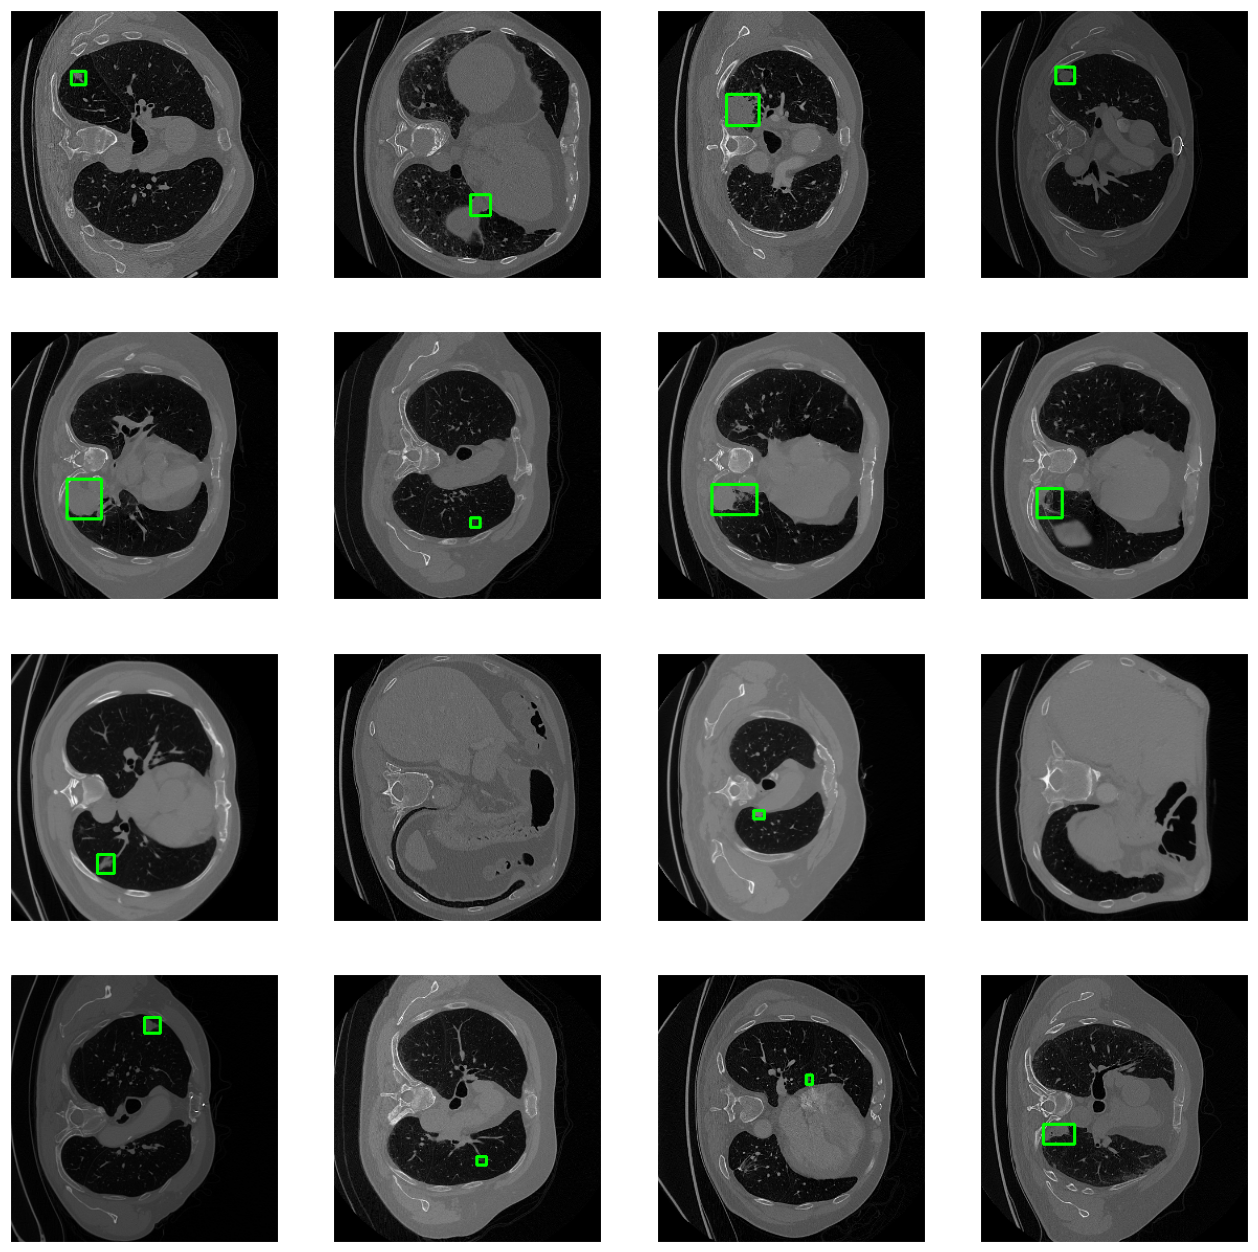

In [ ]:
random_scans = data_loader.random_scans(16)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i, scan in enumerate(random_scans):
    row = i // 4
    col = i % 4
    image, detections = scan
    if len(detections) <= 0:
        axes[row, col].imshow(image)
        continue
    for xmin, ymin, xmax, ymax in detections:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    axes[row, col].imshow(image)
plt.show()

# **⚡Task2: Object Detection**

## **✅Training Yolo Model:**

### **YOLO Model** is object detection algorithm that predict class labels and detects locations of objects as well.

**Data.yaml file** used by the YOLO model during training, validation, or testing to provide information about the dataset and its structure.

In [ ]:
yaml_folder = '''
train: /content/LungTumorDetectionAndSegmentation/train/images_and_detections
val: /content/LungTumorDetectionAndSegmentation/val/images_and_detections
nc: 1
names: ['tumor']
'''

with open("/content/dataset.yaml", "w") as file:
    file.write(yaml_folder)

# use the CLI format to train the model
!yolo train data=/content/dataset.yaml model=yolov8x.pt epochs=40 imgsz=256 optimizer='Adam' lr0=0.0001 weight_decay=0.05 batch=16


100% 131M/131M [00:01<00:00, 104MB/s]
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/dataset.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

**1. Epoch:**
An epoch refers to one complete pass through the entire training dataset.

**2. GPU_mem:**
Amount of GPU memory (VRAM) being used during training.

**3. Box Loss:**
Bounding box regression loss measures how accurately the model predicts the position of bounding boxes around objects. Lower is better.

**4. Cls Loss:**
Classification loss measures how well the model predicts the correct class for each detected object (tumors).Lower is better.

**5. DFL Loss:**
Distribution Focal Loss (DFL) improves the precision of bounding box predictions by refining their coordinates.Lower is better.

**6. Instances:**
The total number of objects (instances) detected in the batch during the current epoch.

**7. Size:**
The image size (input resolution) used for training in this epoch.

**8. Class:**
Summary of evaluation metrics for all classes combined.

**9. Images:**
The total number of images evaluated during the current validation process.

**10. Instances:**
Total number of labeled objects (ground-truth instances) across all validation images.

**11. Box(p):**
Precision for the bounding box predictions. Precision measures the percentage of detected boxes that are correct (true positives).
Range: 0 to 1 (higher is better).

**12. R:**
Recall measures the percentage of ground-truth objects correctly detected by the model. Range: 0 to 1 (higher is better).

**13. mAP50:**
Mean Average Precision (mAP) at IoU=0.50. It measures the accuracy of bounding box predictions when the Intersection over Union (IoU) threshold is 50%. Range: 0 to 1 (higher is better).

**14. mAP50-95:**
Mean Average Precision (mAP) averaged over multiple IoU thresholds (from 0.50 to 0.95, step = 0.05). This is a stricter evaluation metric.
Range: 0 to 1 (higher is better).

**Make Predictions on training dataset**

In [ ]:
!yolo predict model=/content/runs/detect/train/weights/best.pt \
    source=/content/LungTumorDetectionAndSegmentation/train/images \
    save_txt=True \
    project=/content/LungTumorDetectionAndSegmentation/train/predicted_images_and_detections \
    name=output

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs

image 1/1832 /content/LungTumorDetectionAndSegmentation/train/images/Subject_0_0.png: 256x256 (no detections), 34.2ms
image 2/1832 /content/LungTumorDetectionAndSegmentation/train/images/Subject_0_1.png: 256x256 (no detections), 24.0ms
image 3/1832 /content/LungTumorDetectionAndSegmentation/train/images/Subject_0_10.png: 256x256 (no detections), 26.1ms
image 4/1832 /content/LungTumorDetectionAndSegmentation/train/images/Subject_0_100.png: 256x256 (no detections), 23.8ms
image 5/1832 /content/LungTumorDetectionAndSegmentation/train/images/Subject_0_101.png: 256x256 (no detections), 25.2ms
image 6/1832 /content/LungTumorDetectionAndSegmentation/train/images/Subject_0_304.png: 256x256 1 tumor, 19.1ms
image 7/1832 /content/LungTumorDetectionAndSegmentation/train/images/Subject_0_305.png: 256x256 1 tumor, 18.9ms
image 8/1832 /

**Make Predictions on validation dataset**

In [ ]:
!yolo predict model=/content/runs/detect/train/weights/best.pt \
    source=/content/LungTumorDetectionAndSegmentation/val/images \
    save_txt=True \
    project=/content/LungTumorDetectionAndSegmentation/val/predicted_images_and_detections \
    name=output

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs

image 1/98 /content/LungTumorDetectionAndSegmentation/val/images/Subject_57_0.png: 256x256 (no detections), 33.3ms
image 2/98 /content/LungTumorDetectionAndSegmentation/val/images/Subject_57_1.png: 256x256 (no detections), 23.8ms
image 3/98 /content/LungTumorDetectionAndSegmentation/val/images/Subject_57_10.png: 256x256 (no detections), 28.5ms
image 4/98 /content/LungTumorDetectionAndSegmentation/val/images/Subject_57_100.png: 256x256 (no detections), 23.8ms
image 5/98 /content/LungTumorDetectionAndSegmentation/val/images/Subject_57_101.png: 256x256 (no detections), 23.8ms
image 6/98 /content/LungTumorDetectionAndSegmentation/val/images/Subject_57_201.png: 256x256 2 tumors, 28.4ms
image 7/98 /content/LungTumorDetectionAndSegmentation/val/images/Subject_57_202.png: 256x256 1 tumor, 18.9ms
image 8/98 /content/LungTumorDetec

## **✅Evaluation Yolo Model:**

**Evaluate Performance of training dataset**

In [ ]:
train_model = YOLO('/content/runs/detect/train/weights/best.pt')
metrics = train_model.val(conf=0.1, split='train')

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /content/LungTumorDetectionAndSegmentation/train/images_and_detections.cache... 1547 images, 285 backgrounds, 0 corrupt: 100%|██████████| 1832/1832 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:31<00:00,  3.67it/s]


                   all       1832       1677      0.941      0.774      0.879       0.67
Speed: 0.2ms preprocess, 12.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val


**Evaluate Performance of validation dataset**

In [ ]:
val_model = YOLO('/content/runs/detect/train/weights/best.pt')
metrics = val_model.val(conf=0.1, split='val')

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /content/LungTumorDetectionAndSegmentation/val/images_and_detections.cache... 78 images, 20 backgrounds, 0 corrupt: 100%|██████████| 98/98 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]


                   all         98         86      0.847      0.616      0.744      0.433
Speed: 0.5ms preprocess, 13.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val2


**Confusin Matrix**

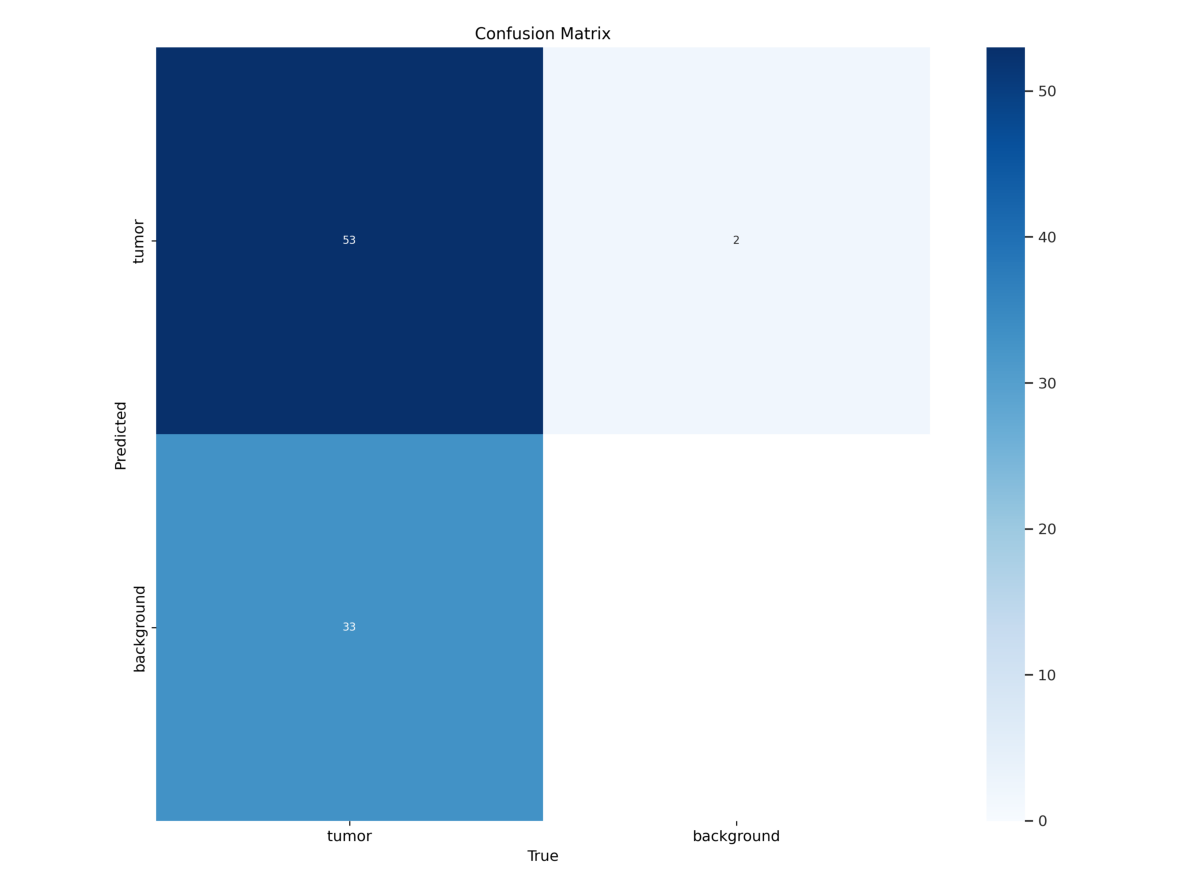

In [ ]:
img = mpimg.imread('/content/runs/detect/train/confusion_matrix.png')
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(img)
ax.axis('off');

# **⚡Task3: Semantic Segmentation On Full Image**

## **✅Training UNet Model:**

### **UNet Model** is designed for image segmentation, utilizing an encoder-decoder structure with skip connections to preserve spatial information. It is particularly effective for tasks requiring pixel-wise predictions.

**Prepare Dataset for Segmentation**

In [ ]:
def load_dataset(images_path, masks_path, target_size=(256, 256)):
    images, masks = [], []
    image_names = sorted(os.listdir(images_path))

    for img_name in image_names:
        img = load_img(os.path.join(images_path, img_name), target_size=target_size)
        mask = load_img(os.path.join(masks_path, img_name), target_size=target_size, color_mode="grayscale")

        images.append(img_to_array(img) / 255.0)
        masks.append(img_to_array(mask) / 255.0)

    return np.array(images), np.array(masks), image_names

train_images_path = '/content/LungTumorDetectionAndSegmentation/train/images'
train_masks_path = '/content/LungTumorDetectionAndSegmentation/train/masks'

print("Loading training dataset...")
train_images, train_masks, train_names = load_dataset(train_images_path, train_masks_path, target_size = (256, 256))

val_images_path = '/content/LungTumorDetectionAndSegmentation/val/images'
val_masks_path = '/content/LungTumorDetectionAndSegmentation/val/masks'

print("Loading validation dataset...")
val_images, val_masks, val_names = load_dataset(val_images_path, val_masks_path, target_size = (256, 256))


Loading training dataset...
Loading validation dataset...


**Build UNet Model**

In [ ]:
def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    # Concatenate with c3, ensure same size by cropping if necessary
    merge1 = layers.Concatenate()([u1, c3])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    # Concatenate with c2, ensure same size by cropping if necessary
    merge2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u3 = layers.UpSampling2D((2, 2))(c5)
    u3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u3)
    # Concatenate with c1, ensure same size by cropping if necessary
    merge3 = layers.Concatenate()([u3, c1])
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge3)
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c6)
    model = Model(inputs, outputs)
    return model
target_size=(256,256)
model = build_unet(input_shape=(target_size[0], target_size[1], 3))
model.compile(optimizer='adamW', loss='binary_crossentropy', metrics=['accuracy'])

print("Training the model...")
model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=10, batch_size=8)
model.save_weights("/content/UNet.weights.h5")

Training the model...
Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 91s 260ms/step - accuracy: 0.9696 - loss: 0.0891 - val_accuracy: 0.9984 - val_loss: 0.0091
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 94s 164ms/step - accuracy: 0.9955 - loss: 0.0193 - val_accuracy: 0.9984 - val_loss: 0.0101
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9958 - loss: 0.0140 - val_accuracy: 0.9985 - val_loss: 0.0056
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.9973 - loss: 0.0087 - val_accuracy: 0.9988 - val_loss: 0.0033
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 38s 167ms/step - accuracy: 0.9977 - loss: 0.0069 - val_accuracy: 0.9989 - val_loss: 0.0033
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - accuracy: 0.9984 - loss: 0.0043 - val_accuracy: 0.9990 - val_loss: 0.0045
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.9986 - loss: 0.0039 - val_accuracy: 0.9990 - val_loss: 0.0032
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accu

## **✅Evaluation UNet Model:**

**Save the predicted mask**

In [ ]:
def save_predicted_masks(predictions, image_names, save_dir, threshold=0.5, debug=False):
    os.makedirs(save_dir, exist_ok=True)
    for i, (pred, name) in enumerate(zip(predictions, image_names)):
        pred_binary = (pred > threshold).astype(np.uint8) * 255

        pred_binary = np.squeeze(pred_binary, axis=-1)

        pred_binary_3d = np.expand_dims(pred_binary, axis=-1)

        save_path = os.path.join(save_dir, name)
        save_img(save_path, pred_binary_3d)

print("Predicting masks for training images...")
train_preds = model.predict(train_images)

train_save_dir = '/content/LungTumorDetectionAndSegmentation/train/predicted_full_images_masks'
print("Saving predicted masks for training data...")
save_predicted_masks(train_preds, train_names, train_save_dir)

print("Predicting masks for validation images...")
val_preds = model.predict(val_images)

val_save_dir = '/content/LungTumorDetectionAndSegmentation/val/predicted_full_images_masks'
print("Saving predicted masks for validation data...")
save_predicted_masks(val_preds, val_names, val_save_dir)

print("All predicted masks saved successfully!")

Predicting masks for training images...
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step
Saving predicted masks for training data...
Predicting masks for validation images...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
Saving predicted masks for validation data...
All predicted masks saved successfully!


**Calculate the accuracy for train and validation dataset**

In [ ]:
def load_and_preprocess_mask(mask_path, target_size=(256, 256)):
    mask = load_img(mask_path, target_size=target_size)
    mask_array = img_to_array(mask) / 255.0
    mask_array = np.round(mask_array)
    return mask_array

def white_pixel_accuracy(pred_mask, true_mask):
    white_pixel_indices = true_mask > 0.5
    if np.sum(white_pixel_indices) == 0:
        return 1.0

    true_white = true_mask[white_pixel_indices]
    pred_white = pred_mask[white_pixel_indices]

    accuracy_metric = tf.keras.metrics.BinaryAccuracy()
    accuracy_metric.update_state(true_white, pred_white)
    return accuracy_metric.result().numpy()

def calculate_average_white_pixel_accuracy(predicted_masks_dir, actual_masks_dir, target_size=(256, 256)):
    predicted_masks = sorted(os.listdir(predicted_masks_dir))
    actual_masks = sorted(os.listdir(actual_masks_dir))

    num_images = len(actual_masks)
    total_accuracy = 0

    for pred_mask_file, true_mask_file in zip(predicted_masks, actual_masks):
        pred_mask_path = os.path.join(predicted_masks_dir, pred_mask_file)
        true_mask_path = os.path.join(actual_masks_dir, true_mask_file)

        predicted_mask = load_and_preprocess_mask(pred_mask_path, target_size)
        actual_mask = load_and_preprocess_mask(true_mask_path, target_size)

        accuracy = white_pixel_accuracy(predicted_mask, actual_mask)
        total_accuracy += accuracy

    return total_accuracy / num_images

dataset_paths = {
    "training": {
        "predicted": "/content/LungTumorDetectionAndSegmentation/train/predicted_full_images_masks",
        "actual": "/content/LungTumorDetectionAndSegmentation/train/masks"
    },
    "validation": {
        "predicted": "/content/LungTumorDetectionAndSegmentation/val/predicted_full_images_masks",
        "actual": "/content/LungTumorDetectionAndSegmentation/val/masks"
    }
}

for dataset_type, paths in dataset_paths.items():
    avg_accuracy = calculate_average_white_pixel_accuracy(paths["predicted"], paths["actual"])
    print(f"Average White Pixel Accuracy for {dataset_type.capitalize()} Dataset: {avg_accuracy}")


Average Pixel Accuracy for Training Dataset: 0.9987480463419419
Average Pixel Accuracy for Validation Dataset: 0.9989516589106345


# **⚡Task4: Evaluating UNet Model Trained on Full Images Using Cropped Detections By Yolo**




## **✅Cropped Tumor Detection:**

In [ ]:
def load_yolo_detections_predictions(annotations_path):
    with open(annotations_path, 'r') as f:
        annotations = f.readlines()
    bboxes = []
    for annotation in annotations:
        parts = annotation.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        bboxes.append((class_id, x_center, y_center, width, height))
    return bboxes

def crop_and_save_image(image, annotations, image_name, save_dir, image_width, image_height):
    for i, (class_id, x_center, y_center, width, height) in enumerate(annotations):
        x1 = int((x_center - width / 2) * image_width)
        y1 = int((y_center - height / 2) * image_height)
        x2 = int((x_center + width / 2) * image_width)
        y2 = int((y_center + height / 2) * image_height)

        cropped_image = image[y1:y2, x1:x2]
        cropped_filename = f"{os.path.splitext(image_name)[0]}_tumor{i+1}.png"

        save_path = os.path.join(save_dir, cropped_filename)
        cv2.imwrite(save_path, cropped_image)

def process_images(image_folder, annotations_folder, save_dir, target_size=(256, 256)):
    os.makedirs(save_dir, exist_ok=True)
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for image_name in tqdm(image_files):
        image_path = os.path.join(image_folder, image_name)
        annotations_path = os.path.join(annotations_folder, f"{os.path.splitext(image_name)[0]}.txt")

        if not os.path.exists(annotations_path):
            continue

        image = cv2.imread(image_path)
        image_height, image_width = image.shape[:2]

        annotations = load_yolo_detections_predictions(annotations_path)
        crop_and_save_image(image, annotations, image_name, save_dir, image_width, image_height)


train_image_folder = '/content/LungTumorDetectionAndSegmentation/train/images'
train_mask_folder = '/content/LungTumorDetectionAndSegmentation/train/masks'
train_annotations_folder = '/content/LungTumorDetectionAndSegmentation/train/predicted_images_and_detections/output/labels'
train_images_save_dir = '/content/LungTumorDetectionAndSegmentation/train/cropped_images_with_pred_detections'
train_masks_save_dir = '/content/LungTumorDetectionAndSegmentation/train/cropped_masks_with_pred_detections'

print("Processing training images...")
process_images(train_image_folder, train_annotations_folder, train_images_save_dir)
process_images(train_mask_folder, train_annotations_folder, train_masks_save_dir)

val_image_folder = '/content/LungTumorDetectionAndSegmentation/val/images'
val_mask_folder = '/content/LungTumorDetectionAndSegmentation/val/masks'
val_annotations_folder = '/content/LungTumorDetectionAndSegmentation/val/predicted_images_and_detections/output/labels'
val_images_save_dir = '/content/LungTumorDetectionAndSegmentation/val/cropped_images_with_pred_detections'
val_masks_save_dir = '/content/LungTumorDetectionAndSegmentation/val/cropped_masks_with_pred_detections'

print("Processing validation images...")
process_images(val_image_folder, val_annotations_folder, val_images_save_dir)
process_images(val_mask_folder, val_annotations_folder, val_masks_save_dir)

Processing training images...


100%|██████████| 1832/1832 [00:00<00:00, 2385.76it/s]


Processing validation images...


100%|██████████| 98/98 [00:00<00:00, 2826.93it/s]


## **✅Apply Segmentation:**

In [ ]:
model = build_unet(input_shape=(256, 256, 3))
model_path = '/content/UNet.weights.h5'
model.load_weights(model_path)

cropped_train_images_folder = '/content/LungTumorDetectionAndSegmentation/train/cropped_images_with_pred_detections'
cropped_train_masks_folder = '/content/LungTumorDetectionAndSegmentation/train/cropped_masks_with_pred_detections'
predicted_train_masks_folder = '/content/LungTumorDetectionAndSegmentation/train/predicted_masks_pred_detections'

print("Loading and predicting masks for training cropped images...")
cropped_train_images,cropped_train_masks, train_image_names = load_dataset(cropped_train_images_folder,cropped_train_masks_folder, target_size=(256, 256))
train_masks_predictions = model.predict(cropped_train_images)
save_predicted_masks(train_masks_predictions, train_image_names, predicted_train_masks_folder)

cropped_val_images_folder = '/content/LungTumorDetectionAndSegmentation/val/cropped_images_with_pred_detections'
cropped_val_masks_folder = '/content/LungTumorDetectionAndSegmentation/val/cropped_masks_with_pred_detections'
predicted_val_masks_folder = '/content/LungTumorDetectionAndSegmentation/val/predicted_masks_pred_detections'

print("Loading and predicting masks for validation cropped images...")
cropped_val_images,cropped_val_masks, val_image_names = load_dataset(cropped_val_images_folder,cropped_val_masks_folder, target_size=(256, 256))
val_masks_predictions = model.predict(cropped_val_images)
save_predicted_masks(val_masks_predictions, val_image_names, predicted_val_masks_folder)

print("Prediction and saving of masks completed.")


Loading and predicting masks for training cropped images...
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step
Loading and predicting masks for validation cropped images...
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Prediction and saving of masks completed.


## **✅Evaluation:**

In [ ]:
dataset_paths = {
    "training": {
        "predicted": "/content/LungTumorDetectionAndSegmentation/train/predicted_masks_pred_detections",
        "actual": "/content/LungTumorDetectionAndSegmentation/train/masks"
    },
    "validation": {
        "predicted": "/content/LungTumorDetectionAndSegmentation/val/predicted_masks_pred_detections",
        "actual": "/content/LungTumorDetectionAndSegmentation/val/masks"
    }
}

for dataset_type, paths in dataset_paths.items():
    avg_accuracy = calculate_average_pixel_accuracy(paths["predicted"], paths["actual"])
    print(f"Average Pixel Accuracy for {dataset_type.capitalize()} Dataset: {avg_accuracy}")

Average Pixel Accuracy for Training Dataset: 0.7437627117706699
Average Pixel Accuracy for Validation Dataset: 0.6281873741928412


# **⚡Task5: UNet Segmentation Model Trained on Cropped Masks**

## **✅Training:**

In [ ]:
cropped_train_images_folder = '/content/LungTumorDetectionAndSegmentation/train/cropped_images'
cropped_train_masks_folder = '/content/LungTumorDetectionAndSegmentation/train/cropped_masks'

print("Loading and predicting masks for training cropped images...")
cropped_train_images,cropped_train_masks, train_image_names = load_dataset(cropped_train_images_folder,cropped_train_masks_folder, target_size=(256, 256))

cropped_val_images_folder = '/content/LungTumorDetectionAndSegmentation/val/cropped_images'
cropped_val_masks_folder = '/content/LungTumorDetectionAndSegmentation/val/cropped_masks'

print("Loading and predicting masks for validation cropped images...")
cropped_val_images, cropped_val_masks, val_image_names = load_dataset(cropped_val_images_folder,cropped_val_masks_folder, target_size=(256, 256))

model = build_unet(input_shape=(target_size[0], target_size[1], 3))
model.compile(optimizer='adamW', loss='binary_crossentropy', metrics=['accuracy'])

print("Training the model...")
model.fit(cropped_train_images, cropped_train_masks, validation_data=(cropped_val_images, cropped_val_masks), epochs=10, batch_size=8)
model.save_weights("/content/UNet_cropped_images.weights.h5")

Loading and predicting masks for training cropped images...
Loading and predicting masks for validation cropped images...
Training the model...
Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 77s 319ms/step - accuracy: 0.5971 - loss: 0.5837 - val_accuracy: 0.5861 - val_loss: 0.5159
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 45s 164ms/step - accuracy: 0.6436 - loss: 0.4893 - val_accuracy: 0.6712 - val_loss: 0.4528
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.6586 - loss: 0.4661 - val_accuracy: 0.6486 - val_loss: 0.4521
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.6637 - loss: 0.4638 - val_accuracy: 0.6805 - val_loss: 0.4228
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.6760 - loss: 0.4577 - val_accuracy: 0.6703 - val_loss: 0.4382
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 35s 167ms/step - accuracy: 0.6856 - loss: 0.4378 - val_accuracy: 0.6751 - val_loss: 0.4336
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - accuracy: 0.6

In [ ]:
predicted_train_masks_folder = '/content/LungTumorDetectionAndSegmentation/train/predicted_masks_actual_detections'
train_masks_predictions = model.predict(cropped_train_images)
save_predicted_masks(train_masks_predictions, train_image_names, predicted_train_masks_folder)

predicted_val_masks_folder = '/content/LungTumorDetectionAndSegmentation/val/predicted_masks_actual_detections'
val_masks_predictions = model.predict(cropped_val_images)
save_predicted_masks(val_masks_predictions, val_image_names, predicted_val_masks_folder)

print("Prediction and saving of masks completed.")

53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step
Prediction and saving of masks completed.


## **✅Evaluation:**

In [ ]:
dataset_paths = {
    "training": {
        "predicted": "/content/LungTumorDetectionAndSegmentation/train/predicted_masks_actual_detections",
        "actual": "/content/LungTumorDetectionAndSegmentation/train/masks"
    },
    "validation": {
        "predicted": "/content/LungTumorDetectionAndSegmentation/val/predicted_masks_actual_detections",
        "actual": "/content/LungTumorDetectionAndSegmentation/val/masks"
    }
}

for dataset_type, paths in dataset_paths.items():
    avg_accuracy = calculate_average_pixel_accuracy(paths["predicted"], paths["actual"])
    print(f"Average Pixel Accuracy for {dataset_type.capitalize()} Dataset: {avg_accuracy}")

Average Pixel Accuracy for Training Dataset: 0.15636942167990073
Average Pixel Accuracy for Validation Dataset: 0.15222105687978316
